In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class TwoPathConv(nn.Module):
    def __init__(self):
        super(TwoPathConv, self).__init__()
        self.upper_layer1 = nn.Sequential(
            nn.Conv2d(4,64,7),
            nn.ReLU(),
            nn.MaxPool2d((4,4),stride = 1)
        )
        self.upper_layer2 = nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride = 1)
        )
        self.under_layer1 = nn.Sequential(
            nn.Conv2d(4,160,13),
            nn.ReLU()
        )
        self.final_layer = nn.Conv2d(224,5,21)
        #self.upper_conv1 = nn.Conv2d(4,64,7)
        #self.upper_conv2 = nn.Conv2d(64,64,3)
        #self.under_conv1 = nn.Conv2d(4,160,13)
        #self.final_conv = nn.Conv2d(224,5,21)
    
    def forward(self, x):
        upper_x = self.upper_layer2(self.upper_layer1(x))
        under_x = self.under_layer1(x)
        #upper_x = F.max_pool2d(F.relu(self.upper_conv1(x)), (4, 4),stride = 1)
        #upper_x = F.max_pool2d(F.relu(self.upper_conv2(upper_x)), (2, 2), stride = 1)
        #under_x = F.relu(self.under_conv1(x))
        final_x = torch.cat((under_x, upper_x), 1)
        out = self.final_layer(final_x)
        #out = out.view(-1,5)
        return out
        
net = TwoPathConv()
print(net)

x = Variable(torch.randn(1,4,33,33), requires_grad = True)
y_pred = net.forward(x)


class TwoPathConv_alter(nn.Module):
    def __init__(self):
        super(TwoPathConv_alter, self).__init__()
        self.upper_layer1 = nn.Sequential(
            nn.Conv2d(9,64,7),
            nn.ReLU(),
            nn.MaxPool2d((4,4),stride = 1)
        )
        self.upper_layer2 = nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride = 1)
        )
        self.under_layer1 = nn.Sequential(
            nn.Conv2d(9,160,13),
            nn.ReLU()
        )
        self.final_layer = nn.Conv2d(224,5,21)
    def forward(self, x):
        upper_x = self.upper_layer2(self.upper_layer1(x))
        under_x = self.under_layer1(x)
        out = torch.cat((under_x, upper_x), 1)
        return out
        
class Cascaded(nn.Module):
    def __init__(self, net1, net2):
        super(Cascaded, self).__init__()
        self.twopathconv1 = net1
        self.twopathconv2 = net2
        self.final_layer = nn.Conv2d(224, 5, 21)
    def forward(self, x1, x2):
        upper_x = self.twopathconv1(x1)
        lower_x = torch.cat((upper_x, x2), 1)
        final_x = self.twopathconv2(lower_x)
        out = self.final_layer(final_x)
        return out

net1 = TwoPathConv()
net2 = TwoPathConv_alter()
cas_net = Cascaded(net1, net2)
x1 = Variable(torch.randn(1,4,65,65), requires_grad = True)
x2 = Variable(torch.randn(1,4,33,33), requires_grad = True)
y_pred = cas_net.forward(x1, x2)

print(y_pred)

TwoPathConv (
  (upper_layer1): Sequential (
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU ()
    (2): MaxPool2d (size=(4, 4), stride=(1, 1), dilation=(1, 1))
  )
  (upper_layer2): Sequential (
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  )
  (under_layer1): Sequential (
    (0): Conv2d(4, 160, kernel_size=(13, 13), stride=(1, 1))
    (1): ReLU ()
  )
  (final_layer): Conv2d(224, 5, kernel_size=(21, 21), stride=(1, 1))
)
Variable containing:
(0 ,0 ,.,.) = 
 -0.4191

(0 ,1 ,.,.) = 
  0.1881

(0 ,2 ,.,.) = 
  0.3064

(0 ,3 ,.,.) = 
  0.2144

(0 ,4 ,.,.) = 
  0.0517
[torch.FloatTensor of size 1x5x1x1]



In [2]:
#get the training set for phase 1
f=open("training-65x65-balanced.txt", "r")
content=f.readlines()
data=[]
data_train_phase1=[]
i=0
from random import shuffle
shuffle(content)
for line in content:
    no_n_line=line[0:len(line)-1]
    item=no_n_line.split(" ")
    data.append([])
    data[i].append(item[0])
    data[i].append(int(item[1]))
    data[i].append(int(item[2]))
    data[i].append(int(item[3]))
    data[i].append(int(item[4]))
    data_train_phase1.append(data[i])
    i += 1
f.close()
print ("phase 1 data preparation process completed.")

#get the training set for phase 2 and the validation set
data_val=[]
f_in=open("training-65x65-unbalanced.txt", "r")
content=f_in.readlines()
data=[]
data_val=[]
data_train_phase2=[]
i=0
shuffle(content)
for line in content:
    no_n_line=line[0:len(line)-1]
    item=no_n_line.split(" ")
    data.append([])
    data[i].append(item[0])
    data[i].append(int(item[1]))
    data[i].append(int(item[2]))
    data[i].append(int(item[3]))
    data[i].append(int(item[4]))
    if i%75000==0:
        data_val.append(data[i])
    else:
        data_train_phase2.append(data[i])
    i += 1
f_in.close()
print ("phase 2 data preparation process completed.")

import h5py
f = h5py.File('train.h5','r')

phase 1 data preparation process completed.
phase 2 data preparation process completed.


In [3]:
print (len(data))
print (len(data_val))
print (len(data_train_phase1))
print (len(data_train_phase2))

22139022
296
8373078
22138726


In [4]:
print (torch.cuda.is_available())

True


In [5]:
def create_batch_phase1(index, batch_size):
    step=len(data_train_phase1)//batch_size
    starting_index=index%step
    X1_batch = []
    X2_batch = []
    y_batch = []
    while starting_index < len(data_train_phase1):
        case, x, y, z, l = data_train_phase1[starting_index]
        case1 = case[:2]
        case2 = case[3:]
        X1_batch.append(f[case1][case2][:, x-32:x+33, y-32:y+33, z])
        X2_batch.append(f[case1][case2][:, x-16:x+17, y-16:y+17, z])
        y_batch.append(l)
        starting_index+=step
    X1_batch = torch.from_numpy(np.array(X1_batch))
    X2_batch = torch.from_numpy(np.array(X2_batch))
    y_batch = torch.from_numpy(np.array(y_batch))
    return X1_batch, X2_batch, y_batch

def create_batch_phase2(index, batch_size):
    step=len(data_train_phase2)//batch_size
    starting_index=index%step
    X1_batch = []
    X2_batch = []
    y_batch = []
    while starting_index < len(data_train_phase2):
        case, x, y, z, l = data_train_phase2[starting_index]
        case1 = case[:2]
        case2 = case[3:]
        X1_batch.append(f[case1][case2][:, x-32:x+33, y-32:y+33, z])
        X2_batch.append(f[case1][case2][:, x-16:x+17, y-16:y+17, z])
        y_batch.append(l)
        starting_index+=step
    X1_batch = torch.from_numpy(np.array(X1_batch))
    X2_batch = torch.from_numpy(np.array(X2_batch))
    y_batch = torch.from_numpy(np.array(y_batch))
    return X1_batch, X2_batch, y_batch

def create_val(batch_mask):
    X1_val=[]
    X2_val=[]
    y_val=[]
    for i in range(len(batch_mask)):
        case, x, y, z, l = data_val[batch_mask[i]]
        case1 = case[:2]
        case2 = case[3:]
        X2_val.append(f[case1][case2][:, x-16:x+17, y-16:y+17, z])
        X1_val.append(f[case1][case2][:, x-32:x+33, y-32:y+33, z])
        y_val.append(l)
    X1_val = torch.from_numpy(np.array(X1_val))
    X2_val = torch.from_numpy(np.array(X2_val))
    y_val = torch.from_numpy(np.array(y_val))
    return X1_val, X2_val, y_val

In [6]:
import multiprocessing
from multiprocessing import Queue

def Process1(index, batch_size, nprocs=4):
    def worker(index, batch_size, out_q):
        if start>=len(data_train_phase1):
            return
        end=start+batch_size
        if end>=len(data_train_phase1):
            end=len(data_train_phase1)
        X1_batch = []
        X2_batch = []
        y_batch = []
        for index in range(start, end):
            case, x, y, z, l = data_train_phase1[index]
            case1 = case[:2]
            case2 = case[3:]
            X1_batch.append(f[case1][case2][:, x-32:x+33, y-32:y+33, z])
            X2_batch.append(f[case1][case2][:, x-16:x+17, y-16:y+17, z])
            y_batch.append(l)
        X1_batch = np.array(X1_batch)
        X2_batch = np.array(X2_batch)
        y_batch = np.array(y_batch)
        out_q.put((X1_batch, X2_batch, y_batch))
    
    out_q=Queue()
    procs=[]
    batch_len=batch_size//nprocs
    start=(index*batch_size)%len(data_train_phase1)
    for i in range(nprocs):
        start_index=start+i*batch_len
        p = multiprocessing.Process(
                target=worker,
                args=(start_index, batch_len, out_q))
        procs.append(p)
        p.start()
    X1_list=[]
    X2_list=[]
    y_list=[]
    for i in range(nprocs):
        X1_frac, X2_frac, y_frac=out_q.get()
        X1_list.append(torch.from_numpy(X1_frac))
        X2_list.append(torch.from_numpy(X2_frac))
        y_list.append(torch.from_numpy(y_frac))
    for p in procs:
        p.join()
    X1_batch=torch.cat(X1_list)
    X2_batch=torch.cat(X2_list)
    y_batch=torch.cat(y_list)
    return X1_batch, X2_batch, y_batch

def Process2(index, batch_size, nprocs=4):
    def worker(index, batch_size, out_q):
        if start>=len(data_train_phase2):
            return
        end=start+batch_size
        if end>=len(data_train_phase2):
            end=len(data_train_phase2)
        X1_batch = []
        X2_batch = []
        y_batch = []
        for index in range(start, end):
            case, x, y, z, l = data_train_phase2[index]
            case1 = case[:2]
            case2 = case[3:]
            X1_batch.append(f[case1][case2][:, x-32:x+33, y-32:y+33, z])
            X2_batch.append(f[case1][case2][:, x-16:x+17, y-16:y+17, z])
            y_batch.append(l)
        X1_batch = np.array(X1_batch)
        X2_batch = np.array(X2_batch)
        y_batch = np.array(y_batch)
        out_q.put((X1_batch, X2_batch, y_batch))
    
    out_q=Queue()
    procs=[]
    batch_len=batch_size//nprocs
    start=(index*batch_size)%len(data_train_phase2)
    for i in range(nprocs):
        start_index=start+i*batch_len
        p = multiprocessing.Process(
                target=worker,
                args=(start_index, batch_len, out_q))
        procs.append(p)
        p.start()
    X1_list=[]
    X2_list=[]
    y_list=[]
    for i in range(nprocs):
        X1_frac, X2_frac, y_frac=out_q.get()
        X1_list.append(torch.from_numpy(X1_frac))
        X2_list.append(torch.from_numpy(X2_frac))
        y_list.append(torch.from_numpy(y_frac))
    for p in procs:
        p.join()
    X1_batch=torch.cat(X1_list)
    X2_batch=torch.cat(X2_list)
    y_batch=torch.cat(y_list)
    return X1_batch, X2_batch, y_batch

In [7]:
import torch.nn.init as ninit
def init_net(net):
    for param in net.parameters():
        ninit.uniform(param.data, a=-5e-3, b=5e-3)

In [ ]:
import time
import numpy as np
num_train=len(data_train_phase1)
num_val=len(data_val)
batch_size=128
val_size=num_val
num_epoch=2.0
num_times=int(float(num_train)/batch_size*num_epoch)+1
print (num_times)
learning_rate = 5e-3
reg=5e-7
cas_net = Cascaded(net1, net2)
init_net(cas_net)
cas_net.cuda(0)

#create validation set
val_mask=np.random.choice(num_val, val_size)
X1_val, X2_val, y_val=create_val(val_mask)
X1_val, X2_val= Variable(X1_val.cuda(0), requires_grad=False), Variable(X2_val.cuda(0), requires_grad=False)

prev_time = time.clock()
optimizer = torch.optim.SGD(cas_net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=reg)
cas_net.zero_grad()

for i in range(201):  # loop over the dataset multiple times
    X1_batch=None
    X2_batch=None
    X1_batch, X2_batch, y_batch = create_batch_phase1(i, batch_size)
    X1_batch, X2_batch, y_batch = Variable(X1_batch.cuda(0)), Variable(X2_batch.cuda(0)), Variable(y_batch.cuda(0), requires_grad = False)
    y_pred = cas_net.forward(X1_batch, X2_batch)
    y_pred = y_pred.view(-1,5)
    loss = F.cross_entropy(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    cas_net.zero_grad()
    if i % 10 == 0:
        print ("")
        print (str(i)+' time used %.3f' % (time.clock()-prev_time))
        print ('phase 1: '+str(float(i)/num_times*100)+"% completed")
        print (loss)
        y_val_pred=cas_net.forward(X1_val, X2_val)
        y_val_pred=y_val_pred.view(-1,5)
        useless, predicted=torch.max(y_val_pred.data, 1)
        correct = (predicted == y_val.cuda(0)).sum()
        print('Validation accuracy:', float(correct)/val_size)

print ("phase1: successfully trained!")
torch.save(cas_net.state_dict(), "phase1_input_cas_net.txt")
print ("phase1: successfully saved!")

130830

0 time used 0.798
phase 1: 0.0% completed
Variable containing:
 1.6191
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Validation accuracy: 0.08783783783783784

10 time used 9.713
phase 1: 0.007643506840938622% completed
Variable containing:
 1.2667
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Validation accuracy: 0.8716216216216216

20 time used 18.537
phase 1: 0.015287013681877244% completed
Variable containing:
 0.8598
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Validation accuracy: 0.6959459459459459

30 time used 27.488
phase 1: 0.022930520522815866% completed
Variable containing:
 0.9685
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Validation accuracy: 0.875

40 time used 36.757
phase 1: 0.03057402736375449% completed
Variable containing:
 0.9772
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Validation accuracy: 0.8581081081081081

50 time used 45.928
phase 1: 0.038217534204693114% completed
Variable containing:
 0.8875
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Validation accur

In [ ]:
def adam(x, dx, config = None):
    if config is None: 
        config = {}
        config.setdefault('learning_rate',1e-4)
        config.setdefault('beta1',0.9)
        config.setdefault('beta2',0.999)
        config.setdefault('epsilon',1e-8)
        config.setdefault('m',torch.FloatTensor(x.size()).zero_().cuda(0))
        config.setdefault('v',torch.FloatTensor(x.size()).zero_().cuda(0))
        config.setdefault('t',0)
    
    next_x = None
    config['t'] += 1
    x.cuda(0)
    dx.cuda(0)
    config['m'] = config['beta1'] * config['m'] + (1 - config['beta1']) * dx
    config['v'] = config['beta2'] * config['v'] + (1 - config['beta2']) * dx**2
    mb = config['m'] / (1 - config['beta1'] ** config['t'])
    vb = config['v'] / (1 - config['beta2'] ** config['t'])
    next_x = x - config['learning_rate'] * mb / (np.sqrt(vb) + config['epsilon'])
    return next_x, config

def sgd_momentum(w, dw, config = None):

    if config is None: 
        config = {}
        config.setdefault('learning_rate', 5e-4)
        config.setdefault('momentum', 0.9)

    v = config.get('velocity', torch.FloatTensor(w.size()).zero_().cuda(0))
    next_w = None

    v = config['momentum'] * v - config['learning_rate'] * dw
    next_w = w + v
    config['velocity'] = v

    return next_w, config

In [ ]:
import time
import numpy as np
num_train=len(data_train_phase2)
num_val=len(data_val)
batch_size=128
val_size=num_val
num_epoch=2.0
num_times=int(float(num_train)/batch_size*num_epoch)
print (num_times)
learning_rate = 5e-6
reg=5e-7
cas_net = Cascaded(net1, net2)
init_net(cas_net)
cas_net.load_state_dict(torch.load("phase1_input_cas_net.txt"))
cas_net.cuda(0)

# create validation set
val_mask=np.random.choice(num_val, val_size)
X1_val, X2_val, y_val=create_val(val_mask)
X1_val, X2_val=Variable(X1_val.cuda(0), requires_grad=False), Variable(X2_val.cuda(0), requires_grad=False)

prev_time = time.clock()
optimizer = torch.optim.SGD(cas_net.final_layer.parameters(), lr=learning_rate, momentum=0.9, weight_decay=reg)
cas_net.zero_grad()

for i in range(201):  # loop over the dataset multiple times
    X1_batch=None
    X2_batch=None
    X1_batch, X2_batch, y_batch = create_batch_phase2(i, batch_size)
    X1_batch, X2_batch, y_batch = Variable(X1_batch.cuda(0)), Variable(X2_batch.cuda(0)), Variable(y_batch.cuda(0), requires_grad = False)
    y_pred = cas_net.forward(X1_batch, X2_batch)
    y_pred = y_pred.view(-1,5)
    loss = F.cross_entropy(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    cas_net.zero_grad()
    if i % 10 == 0:
        print ("")
        print ('time used %.3f' % (time.clock()-prev_time))
        print ('phase 2: '+str(float(i)/num_times*100)+"% completed")
        print (loss)
        y_val_pred=cas_net.forward(X1_val, X2_val)
        y_val_pred=y_val_pred.view(-1,5)
        useless, predicted=torch.max(y_val_pred.data, 1)
        correct = (predicted == y_val.cuda(0)).sum()
        print('Validation accuracy:', float(correct)/val_size)

print ("phase2: successfully trained!")

torch.save(cas_net.state_dict(), "phase2_input_cas_net.txt")
print ("phase2: successfully saved")

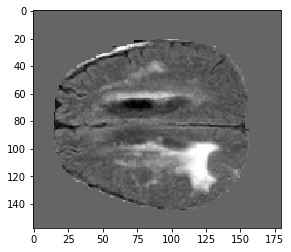

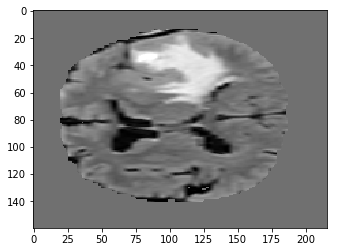

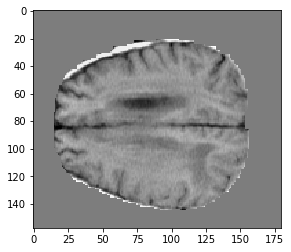

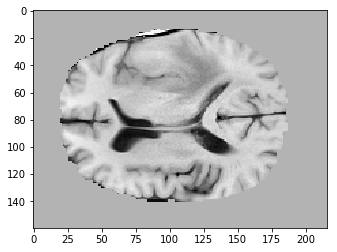

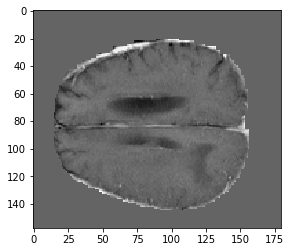

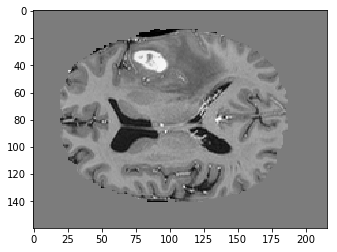

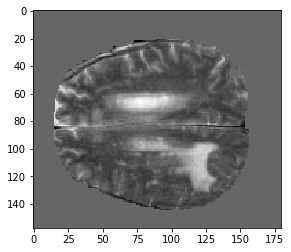

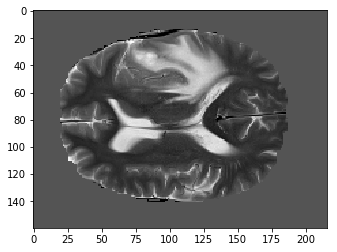

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import h5py
train_f1 = h5py.File('Challenge.h5', 'r')
SAMPLE = [ "HG/0301", "HG/0302",
          "HG/0303", "HG/0304", "HG/0305", "HG/0306", "HG/0307", "HG/0308",
          "HG/0309", "HG/0310", ]

train_f2 = h5py.File('train.h5', 'r')
SAMPLE = [ "LG/0001", "LG/0002", "LG/0004", "LG/0006", "LG/0008", "LG/0011",
          "LG/0012", "LG/0013", "LG/0014", "LG/0015", "HG/0001", "HG/0002",
          "HG/0003", "HG/0004", "HG/0005", "HG/0006", "HG/0007", "HG/0008",
          "HG/0009", "HG/0010", "HG/0011", "HG/0012", "HG/0013", "HG/0014",
          "HG/0015", "HG/0022", "HG/0024", "HG/0025", "HG/0026", "HG/0027",]
for i in range(4):
    plt.imshow(train_f1['HG']['0301'][i,:,:,100], cmap = 'gray')
    plt.show()
    plt.imshow(train_f2['HG']['0001'][i,:,:,100], cmap = 'gray')
    plt.show()
train_f1.close()
train_f2.close()